- 출처 : https://tutorials.pytorch.kr/beginner/dcgan_faces_tutorial.html

#### 1. 초기설정 : 모델 import 및 데이터 로드

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import random


import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # 결과 재현을 위해 필요합니다

Random Seed:  999


In [52]:
# 데이터셋의 경로
dataroot = "data/MNIST"

# dataloader에서 사용할 쓰레드 수
workers = 4

# 배치 크기
batch_size = 128

# 이미지의 크기입니다. 모든 이미지를 변환하여 64로 크기가 통일됩니다.
image_size = 28

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 1

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 학습할 에폭 수
num_epochs = 30

# 옵티마이저의 학습률
G_lr = 0.0004
D_lr = 0.0001

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.0

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

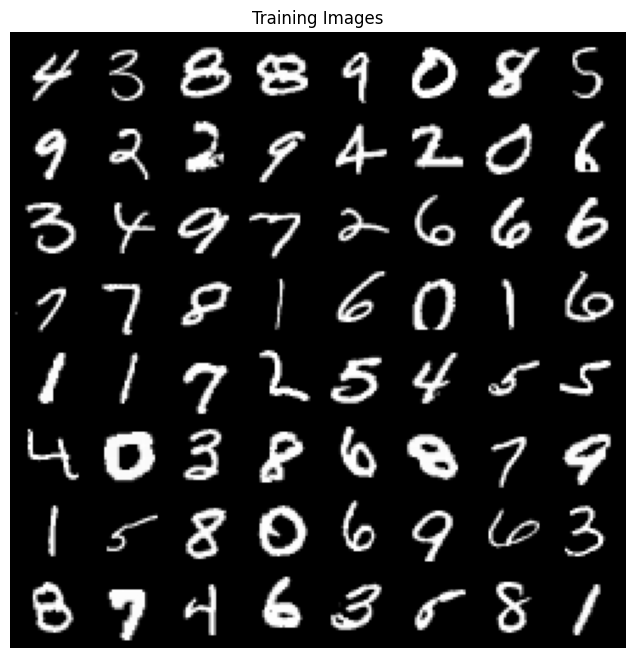

In [53]:
# dataloader를 정의해봅시다
batch_size = 128
image_size = 28
channels = 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

#### 2. 모델 관련된 정의 (가중치초기화, optimizer)

In [54]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def weights_init_he(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
    elif classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

In [55]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256, bias=False),
            nn.BatchNorm1d(256, momentum=0.2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 512, bias=False),
            nn.BatchNorm1d(512, momentum=0.2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 1024, bias=False),
            nn.BatchNorm1d(1024, momentum=0.2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, image_size * image_size * channels),
            nn.Tanh()
        )
        self.latent_dim = latent_dim
    def forward(self, z):
        out = self.model(z)
        out = out.view(z.size(0), channels, image_size, image_size)
        return out

In [56]:
# 생성자를 만듭니다
netG = Generator(nz).to(device)

netG.apply(weights_init_he)

# 모델의 구조를 출력합니다
print(netG)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=False)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size * channels, 512),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out

In [58]:
# 생성자를 만듭니다
netD = Discriminator().to(device)

# netD.apply(weights_init_he)
netD.apply(weights_init_he)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


#### 2.5 옵티마이저 초기화

In [ ]:
# ``BCELoss`` 함수의 인스턴스를 초기화합니다
criterion = nn.BCELoss()
# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(16, nz, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 0.9
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(beta1, 0.999))

In [60]:
# https://github.com/juntang-zhuang/Adabelief-Optimizer?tab=readme-ov-file#installation-and-usage
# from adabelief_pytorch import AdaBelief
# optimizerD = AdaBelief(netD.parameters(), lr=1e-3, eps=1e-16, betas=(0.0,0.999), weight_decouple = True, rectify = True, print_change_log=False)
# optimizerG = AdaBelief(netG.parameters(), lr=1e-3, eps=1e-16, betas=(0.0,0.999), weight_decouple = True, rectify = True, print_change_log=False)

In [ ]:
# Add a learning rate scheduler for the optimizers https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
# schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=5, T_mult=1)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=8, gamma=0.5)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=8, gamma=0.5)

#### 3. 학습 루프

In [ ]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
G_losses_perEpoch = []
D_losses_perEpoch = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    g_losses_epoch = 0.0
    d_losses_epoch = 0.0
    for i, (data, _) in enumerate(train_loader):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data.to(device,non_blocking=True)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        # D_G_z1 -> 생성자 업데이트 후 D_G_z2
        if i % 50 == 0:
            print('[%02d/%d][%03d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        g_losses_epoch += errG.item()
        d_losses_epoch += errD.item()

    D_losses_perEpoch.append(d_losses_epoch / len(train_loader))
    G_losses_perEpoch.append(g_losses_epoch / len(train_loader))

    # Update the learning rate using the scheduler
    schedulerD.step()
    schedulerG.step()

Starting Training Loop...
[00/30][000/469]	Loss_D: 2.2089	Loss_G: 0.8349	D(x): 0.3771	D(G(z)): 0.5216 / 0.5014
[00/30][050/469]	Loss_D: 0.8134	Loss_G: 1.3058	D(x): 0.8093	D(G(z)): 0.3118 / 0.2757
[00/30][100/469]	Loss_D: 1.1523	Loss_G: 1.8275	D(x): 0.8599	D(G(z)): 0.4884 / 0.1619
[00/30][150/469]	Loss_D: 1.5999	Loss_G: 0.5880	D(x): 0.3830	D(G(z)): 0.4257 / 0.5978
[00/30][200/469]	Loss_D: 1.5454	Loss_G: 0.7426	D(x): 0.4764	D(G(z)): 0.5184 / 0.4891
[00/30][250/469]	Loss_D: 1.4313	Loss_G: 0.7422	D(x): 0.4680	D(G(z)): 0.4657 / 0.4808
[00/30][300/469]	Loss_D: 1.2691	Loss_G: 0.8128	D(x): 0.5410	D(G(z)): 0.4400 / 0.4450
[00/30][350/469]	Loss_D: 1.1795	Loss_G: 0.9037	D(x): 0.5579	D(G(z)): 0.3906 / 0.3993
[00/30][400/469]	Loss_D: 1.2427	Loss_G: 0.9428	D(x): 0.5524	D(G(z)): 0.4200 / 0.3886
[00/30][450/469]	Loss_D: 1.2568	Loss_G: 0.9014	D(x): 0.5741	D(G(z)): 0.4521 / 0.4077
[01/30][000/469]	Loss_D: 1.2539	Loss_G: 0.9117	D(x): 0.5356	D(G(z)): 0.4169 / 0.4080
[01/30][050/469]	Loss_D: 1.2888	Loss_G:

#### 4. 학습결과 

BCE 기반 GAN 기준에서:

errD 이론 기준: 1.386

errG 이론 기준: 0.693

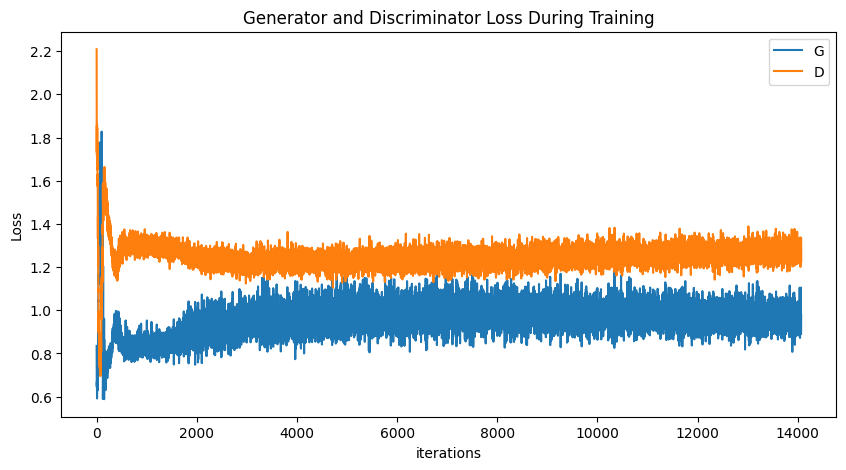

In [63]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [64]:
def print_optimizer_info(opt, name="optimizer"):
    pg = opt.param_groups[0]
    info = {
        "type": opt.__class__.__name__,
        "lr": pg.get("lr"),
        "betas": pg.get("betas"),
        "weight_decay": pg.get("weight_decay"),
        "eps": pg.get("eps"),
        "amsgrad": pg.get("amsgrad", False)
    }
    print(f"{name}:")
    for k, v in info.items():
        print(f"  {k}: {v}")

print_optimizer_info(optimizerD, "optimizerD (Discriminator)")
print_optimizer_info(optimizerG, "optimizerG (Generator)")

# Scheduler 정보가 필요하다면 아래와 같이 출력
if 'schedulerG' in globals():
    sg = schedulerG
    print("\nschedulerG (CosineAnnealingWarmRestarts):")
    print(f"  T_0: {sg.T_0}, T_mult: {sg.T_mult}, eta_min: {sg.eta_min}, last_epoch: {sg.last_epoch}")

optimizerD (Discriminator):
  type: Adam
  lr: 0.0001
  betas: (0.0, 0.999)
  weight_decay: 0
  eps: 1e-08
  amsgrad: False
optimizerG (Generator):
  type: Adam
  lr: 0.0001
  betas: (0.0, 0.999)
  weight_decay: 0
  eps: 1e-08
  amsgrad: False

schedulerG (CosineAnnealingWarmRestarts):
  T_0: 5, T_mult: 1, eta_min: 0.0, last_epoch: 0


In [65]:
if G_losses_perEpoch and D_losses_perEpoch:
    last_idx = len(G_losses_perEpoch) - 1
    print(f"Last epoch ({last_idx}) mean Loss_G: {G_losses_perEpoch[-1]:.4f}, Loss_D: {D_losses_perEpoch[-1]:.4f}")
else:
    print("Epoch loss lists are empty.")

Last epoch (29) mean Loss_G: 0.9696, Loss_D: 1.2706


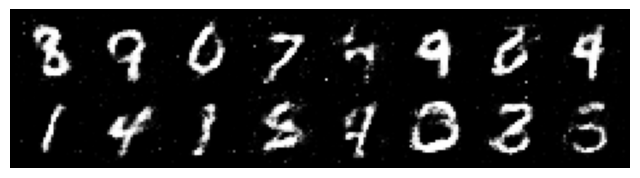

In [66]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

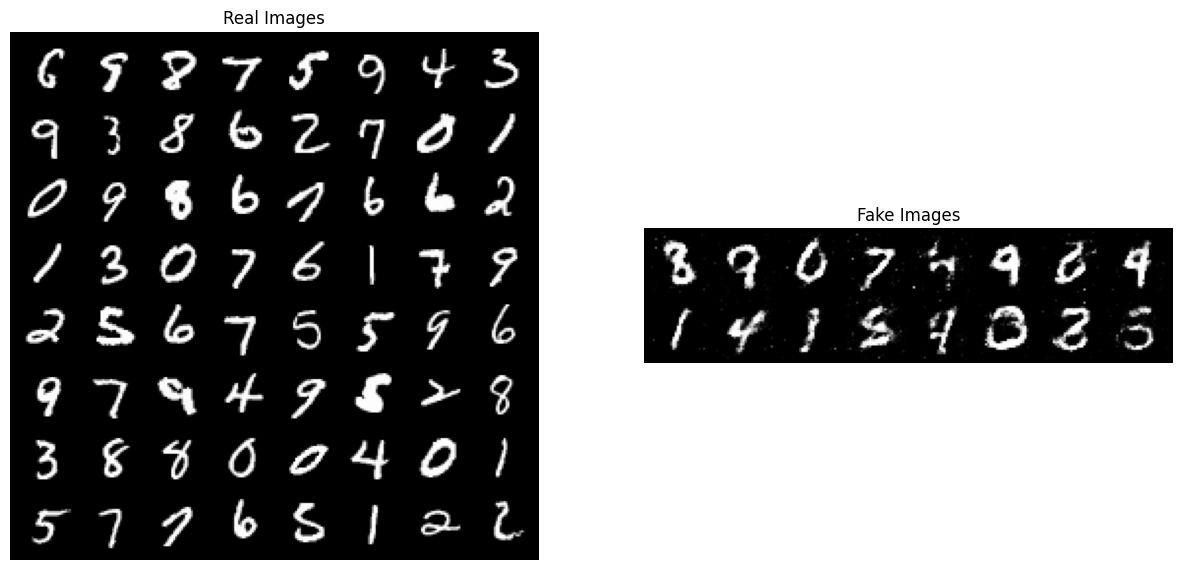

In [67]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(train_loader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

| 항목       | 정상 범위      | 내 값        |
| -------- | ---------- | ---------- | 
| mean     | -0.2 ~ 0.2 | **-0.716** | 
| mean std | 0.2 ~ 0.5  | **0.084**  | 


Generator Output Mean (per image): -0.7353
Generator Output Std Dev (per image): 0.0809


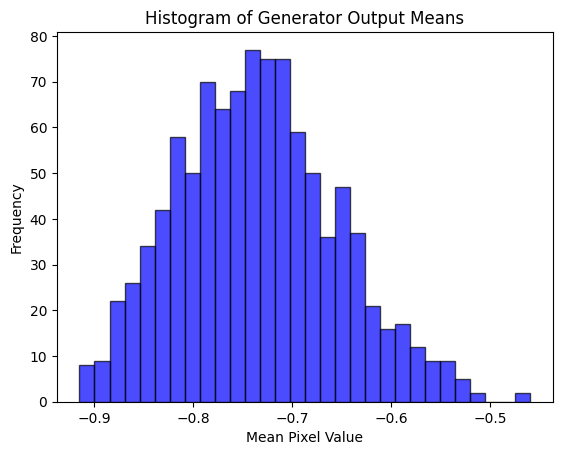

In [68]:
# Check the output distribution of the Generator
with torch.no_grad():
    noise = torch.randn(1000, nz, device=device)  # Generate a large batch of noise
    generated_images = netG(noise).view(1000, -1)  # Flatten the images
    output_means = generated_images.mean(dim=1).cpu().numpy()  # Compute mean per image
    output_overall_mean = output_means.mean()  # Overall mean
    output_overall_std = output_means.std()  # Overall standard deviation
    print(f"Generator Output Mean (per image): {output_overall_mean:.4f}")
    print(f"Generator Output Std Dev (per image): {output_overall_std:.4f}")
    plt.hist(output_means, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title("Histogram of Generator Output Means")
    plt.xlabel("Mean Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

In [69]:
# 자동 FID 계산: real/gan 이미지 저장 후 `fid_score.py`로 비교
import os, shutil
from PIL import Image
# 폴더 준비
os.makedirs('fid_real', exist_ok=True)
os.makedirs('fid_gen', exist_ok=True)
# 기존 이미지 삭제
for d in ['fid_real','fid_gen']:
    for f in os.listdir(d):
        if f.lower().endswith(('.png','.jpg','.jpeg')):
            os.remove(os.path.join(d,f))
# real 이미지 저장 (정규화 역변환: x -> (x*0.5)+0.5)
n_real = 1000
saved = 0
def unnormalize(x):
    return (x * 0.5) + 0.5
for imgs, _ in train_loader:
    imgs = imgs.clone()
    B = imgs.size(0)
    for i in range(B):
        if saved >= n_real: break
        img = imgs[i].cpu()
        img = unnormalize(img).mul(255).clamp(0,255).byte()
        npimg = img.numpy()
        npimg = npimg.squeeze(0)  # (H,W)
        npimg = np.stack([npimg]*3, axis=2)  # to RGB
        im = Image.fromarray(npimg)
        im = im.resize((299,299))
        im.save(f'fid_real/{saved:05d}.png')
        saved += 1
    if saved >= n_real: break
print('Saved', saved, 'real images to fid_real')
# generated 이미지 저장 (Generator는 tanh 출력 [-1,1])
n_gen = 1000
batch_size_save = 100
netG.eval()
saved = 0
while saved < n_gen:
    with torch.no_grad():
        noise = torch.randn(min(batch_size_save, n_gen - saved), nz, device=device)
        gen = netG(noise).cpu()  # (N,1,28,28)
    for i in range(gen.size(0)):
        img = gen[i]
        img = (img * 0.5) + 0.5  # to [0,1]
        img = img.mul(255).clamp(0,255).byte()
        npimg = img.numpy()
        npimg = npimg.squeeze(0)
        npimg = np.stack([npimg]*3, axis=2)
        im = Image.fromarray(npimg)
        im = im.resize((299,299))
        im.save(f'fid_gen/{saved:05d}.png')
        saved += 1
    print('Saved', saved, 'generated images')
# # FID 계산 호출
# from fid_score import calculate_fid_given_paths
# device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
# fid = calculate_fid_given_paths(['fid_real','fid_gen'], batch_size=32, device=device_name)
# print('FID between real and generated:', fid)

Saved 1000 real images to fid_real
Saved 100 generated images
Saved 200 generated images
Saved 300 generated images
Saved 400 generated images
Saved 500 generated images
Saved 600 generated images
Saved 700 generated images
Saved 800 generated images
Saved 900 generated images
Saved 1000 generated images
